In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
import glob
import cv2
import numpy as np
import torch.nn.functional as F
import torch
from PIL import ImageOps
from PIL.Image import Image
from sympy.physics.control.control_plots import plt
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import Subset
from tqdm import tqdm
from PIL import Image


In [2]:


TRAIN_DIR = '/kaggle/input/bkai-igh-neopolyp/train/train/'
TRAIN_MASK_DIR = '/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt/'
TEST_DIR = '/kaggle/input/bkai-igh-neopolyp/test/test/'

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


number_image_train = 1000 # max  = 1000

In [5]:
image_path = []
for root, dirs, files in os.walk(TRAIN_DIR):
    # iterate over 1000 images
    for file in files:
        # create path
        path = os.path.join(root,file)
        # add path to list
        image_path.append(path)
len(image_path)

1000

In [3]:
mask_path = []
for root, dirs, files in os.walk(TRAIN_MASK_DIR):
    #iterate over 1000 masks
    for file in files:
        # obtain the path
        path = os.path.join(root,file)
        # add path to the list
        mask_path.append(path)
len(mask_path)

1000

In [6]:
%%time
images = []
transform = transforms.ToTensor()
for path in tqdm(image_path[:number_image_train]):
    # Read image using PIL
    image = Image.open(path)
    # Apply the transformation to convert the image to a tensor
    image = np.array(image)
    # Append the tensor image to the list
    images.append(image)

100%|██████████| 1000/1000 [00:19<00:00, 52.49it/s]

CPU times: user 9.72 s, sys: 2.09 s, total: 11.8 s
Wall time: 19.1 s


In [7]:
%%time
images_mask = []
transform = transforms.ToTensor()
for path in tqdm(mask_path[:number_image_train]):
    # Read image using PIL
    image = Image.open(path)
    # Apply the transformation to convert the image to a tensor
    image = np.array(image)
    # Append the tensor image to the list
#     r, g, b = cv2.split(image)

#     # Định nghĩa mặt nạ cho vùng màu xanh
#     mask = g > np.maximum(r, b)
#     image[..., 1][mask] = 0  # Kênh màu xanh thành 0 (màu đỏ)
#     image[..., 0][mask] = 255  # Kênh màu đỏ thành 255 (màu xanh)


#     green_color = np.array([0, 255, 1])

#     # Tìm các pixel có màu xanh và thay đổi thành màu đỏ
#     green_pixels = np.all(image == green_color, axis=2)
#     image[green_pixels] = [254, 0, 0]
    images_mask.append(image)
#     print(image.shape)

100%|██████████| 1000/1000 [00:12<00:00, 82.24it/s]

CPU times: user 5.63 s, sys: 1.99 s, total: 7.63 s
Wall time: 12.2 s


In [19]:
class PolypDataset(Dataset):
    def __init__(self, images, transform=None):
        self.dataset = images
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):        
        resized_image = cv2.resize(images[idx], (224, 224))
        RGB = resized_image[:, :, 0:].astype(np.float32) / 127.5 -1

#         # Extract AB channels and normalize to [-1, 1]
#         G = resized_image[:, :, 1].astype(np.float32) / 127.5 - 1.0
#         B = resized_image[:, :, 2].astype(np.float32) / 127.5 - 1.0

        # Convert to tensor and reshape for input to network
#         L = torch.from_numpy(L).unsqueeze(0)
#         AB = torch.from_numpy(AB.transpose((2, 0, 1)))
        RGB = torch.from_numpy(RGB).permute(2, 0, 1)

        return RGB

In [9]:
class PolypDatasetTest(Dataset):
    def __init__(self, images_mask, transform=None):
        self.dataset = images_mask
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    def read_mask(self, idx):
#         image = cv2.imread(mask_path)
        image = cv2.resize(image, (224, 224))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        # lower boundary RED color range values; Hue (0 - 10)
        lower1 = np.array([0, 100, 20])
        upper1 = np.array([10, 255, 255])
        # upper boundary RED color range values; Hue (160 - 180)
        lower2 = np.array([160,100,20])
        upper2 = np.array([179,255,255])
        lower_mask = cv2.inRange(image, lower1, upper1)
        upper_mask = cv2.inRange(image, lower2, upper2)
        red_mask = lower_mask + upper_mask;
        red_mask[red_mask != 0] = 2
        # boundary RED color range values; Hue (36 - 70)
        green_mask = cv2.inRange(image, (36, 25, 25), (70, 255,255))
        green_mask[green_mask != 0] = 1
        full_mask = cv2.bitwise_or(red_mask, green_mask)
        full_mask = full_mask.astype(np.uint8)
        return full_mask

    def __getitem__(self, idx):   
        resized_image = cv2.resize(images_mask[idx], (224, 224))
        image = cv2.cvtColor(resized_image, cv2.COLOR_RGB2HSV)

        lower1 = np.array([0, 100, 20])
        upper1 = np.array([10, 255, 255])
        # upper boundary RED color range values; Hue (160 - 180)
        lower2 = np.array([160,100,20])
        upper2 = np.array([179,255,255])
        lower_mask = cv2.inRange(image, lower1, upper1)
        upper_mask = cv2.inRange(image, lower2, upper2)
        red_mask = lower_mask + upper_mask;
#         print("red_mask: ",red_mask.shape)
        red_mask[red_mask != 0] = 1
        # boundary RED color range values; Hue (36 - 70)
        green_mask = cv2.inRange(image, (36, 25, 25), (70, 255,255))
#         print("gr_mask: ",green_mask.shape)
        green_mask[green_mask != 0] = 2
#         print("gr_after", green_mask.shape)
        full_mask = cv2.bitwise_or(red_mask, green_mask)
        full_mask = full_mask.astype(np.uint8)
        return full_mask

In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        else:
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

    
class ColorizationModel(nn.Module):
    def __init__(self, out_classes=3, up_sample_mode='conv_transpose'):
        super(ColorizationModel, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x

In [12]:
class PolypModel(nn.Module):
    def __init__(self, out_classes=3, up_sample_mode='conv_transpose'):
        super(PolypModel, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)
        self.final_activation = nn.Softmax(dim=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
#         print(x.shape)
#         x = self.final_activation(x)
        return x

In [25]:
learning_rate = 0.0001
batch_size = 32
num_epochs = 3000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# criterion = nn.L1Loss()
criterion = nn.CrossEntropyLoss()
model_colorization = ColorizationModel().to(device)
checkpoint = torch.load('/kaggle/input/color-rgb/colorization_model_23 (1).pth')
model_colorization.load_state_dict(checkpoint['model_state_dict'])
model_segmentation = PolypModel().to(device)

model_segmentation.down_conv1.load_state_dict(model_colorization.down_conv1.state_dict())
model_segmentation.down_conv2.load_state_dict(model_colorization.down_conv2.state_dict())
model_segmentation.down_conv3.load_state_dict(model_colorization.down_conv3.state_dict())
model_segmentation.down_conv4.load_state_dict(model_colorization.down_conv4.state_dict())
model_segmentation.down_conv1.requires_grad_(False)
model_segmentation.down_conv2.requires_grad_(False)
model_segmentation.down_conv3.requires_grad_(False)
model_segmentation.down_conv4.requires_grad_(False)

optimizer = torch.optim.Adam(model_segmentation.parameters(), lr=learning_rate)





In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.0001
batch_size = 2
num_epochs = 3000
criterion = nn.L1Loss()
model = ColorizationModel().to(device)
checkpoint = torch.load('/kaggle/input/model512/colorization_model_7 (2).pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
L_epoch = checkpoint['epoch']
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# optimizer = checkpoint['optimizer_state_dict']


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/model512/colorization_model_7 (2).pth'

In [20]:
train_size = int(0.8 * len(PolypDataset(images)))
print(train_size)
test_size = len(PolypDataset(images)) - train_size
print(test_size)
train_indices = list(range(train_size))
test_indices = list(range(train_size, train_size + test_size))

train_dataset = Subset(PolypDataset(images), train_indices)
test_dataset = Subset(PolypDataset(images), test_indices)
mask_dataset = Subset(PolypDatasetTest(images_mask), train_indices)
test_mask_dataset = Subset(PolypDatasetTest(images_mask), test_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader =  DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
mask_loader = DataLoader(mask_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_mask_loader = DataLoader(test_mask_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
print(len(test_loader))

800
200
7


In [26]:
for epoch in range(num_epochs):
# for epoch in range(num_epochs):
# for epoch in range(L_epoch, num_epochs):
    # Train on batches
    train_loss = 0
    for RGB, RGBt in zip(train_loader,mask_loader):
        RGB=RGB.to(device)
        RGBt=RGBt.to(device)
        # Zero gradients
        optimizer.zero_grad()
#         RGB.permute(3, 2, 1, 0)
#         print(RGB.shape)
        # Forward pass
        outputs = model_segmentation(RGB)
        outputs = outputs.squeeze()
#         print(L.shape)
#         print(outputs.shape)
#         print(AB.shape)

        # Compute loss
        RGBt = RGBt.long()
#         print(outputs.shape)
#         print(RGBt.shape)
        loss = criterion(outputs, RGBt)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update train loss
        train_loss += loss.item()

    # Compute validation loss
    val_loss = 0
    with torch.no_grad():
        for RGB, RGBt in zip(test_loader,test_mask_loader):
            RGB=RGB.to(device)
            RGBt=RGBt.to(device)
            # Forward pass
            outputs = model_segmentation(RGB)
            outputs = outputs.squeeze()
            RGBt = RGBt.long()

            # Compute loss
            loss = criterion(outputs, RGBt)

            # Update validation loss
            val_loss += loss.item()

    # Print loss
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(test_loader):.4f}")
    if (epoch+1)%30 ==0:
        checkpoint = {
        'epoch': epoch,
        'model_state_dict': model_segmentation.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        }
        save_path = f'colorization_model_{epoch//30}.pth'

        torch.save(checkpoint, save_path)
torch.save(model_segmentation.state_dict(), 'colorization_model.pth')

Epoch 1/3000, Train Loss: 0.9785, Validation Loss: 0.7470
Epoch 2/3000, Train Loss: 0.6439, Validation Loss: 0.5949
Epoch 3/3000, Train Loss: 0.5429, Validation Loss: 0.5333
Epoch 4/3000, Train Loss: 0.4952, Validation Loss: 0.4852
Epoch 5/3000, Train Loss: 0.4375, Validation Loss: 0.4459
Epoch 6/3000, Train Loss: 0.3969, Validation Loss: 0.4109
Epoch 7/3000, Train Loss: 0.3629, Validation Loss: 0.3964
Epoch 8/3000, Train Loss: 0.3379, Validation Loss: 0.3697
Epoch 9/3000, Train Loss: 0.3125, Validation Loss: 0.3596
Epoch 10/3000, Train Loss: 0.2882, Validation Loss: 0.3508
Epoch 11/3000, Train Loss: 0.2701, Validation Loss: 0.3225
Epoch 12/3000, Train Loss: 0.2514, Validation Loss: 0.3085
Epoch 13/3000, Train Loss: 0.2363, Validation Loss: 0.3003
Epoch 14/3000, Train Loss: 0.2220, Validation Loss: 0.2871
Epoch 15/3000, Train Loss: 0.2085, Validation Loss: 0.2728
Epoch 16/3000, Train Loss: 0.1974, Validation Loss: 0.2613
Epoch 17/3000, Train Loss: 0.1850, Validation Loss: 0.2564
Epoch 

KeyboardInterrupt: 

In [27]:
color_dict = {0: (0,   0, 0),
              1: (255, 0,   0),
              2: (0, 255,   0)}
def mask_to_rgb(mask, color_dict):
    output = np.zeros((mask.shape[0], mask.shape[1], 3))
#     print(output.shape)
    for k in color_dict.keys():
        output[np.round(mask)==k] = color_dict[k]

    return np.uint8(output)

tensor(0)
outputs torch.Size([3, 224, 224])


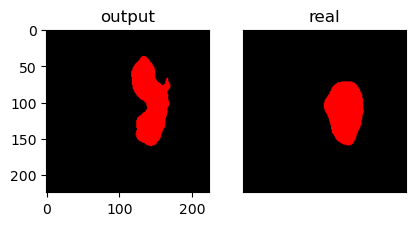

tensor(0)
outputs torch.Size([3, 224, 224])


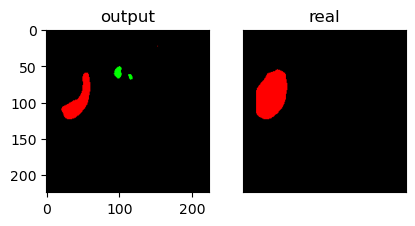

tensor(0)
outputs torch.Size([3, 224, 224])


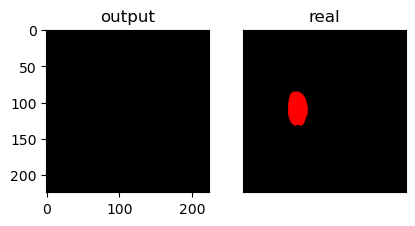

tensor(0)
outputs torch.Size([3, 224, 224])


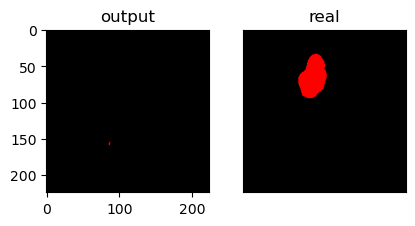

tensor(0)
outputs torch.Size([3, 224, 224])


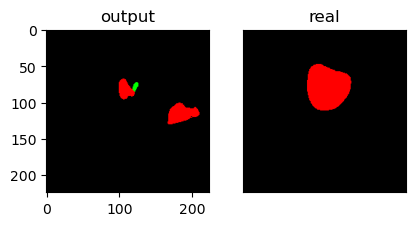

tensor(0)
outputs torch.Size([3, 224, 224])


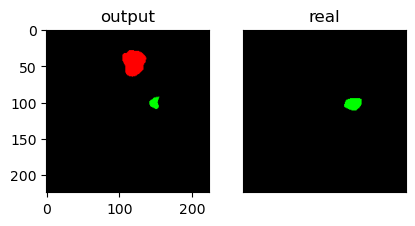

tensor(0)
outputs torch.Size([3, 224, 224])


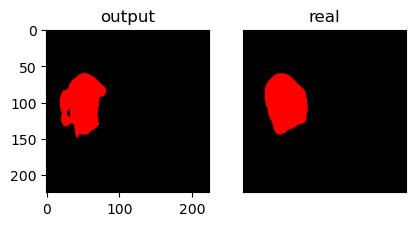

tensor(0)
outputs torch.Size([3, 224, 224])


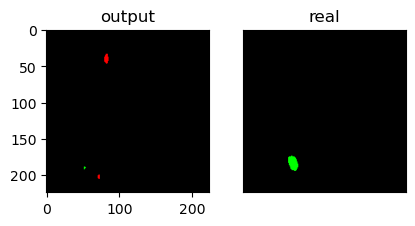

tensor(0)
outputs torch.Size([3, 224, 224])


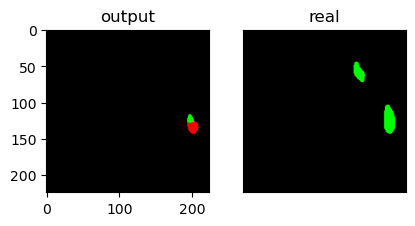

tensor(0)
outputs torch.Size([3, 224, 224])


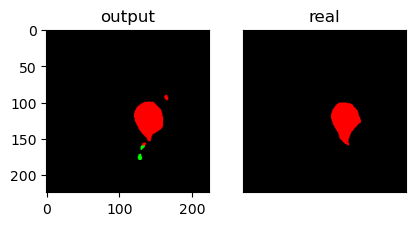

tensor(0)
outputs torch.Size([3, 224, 224])


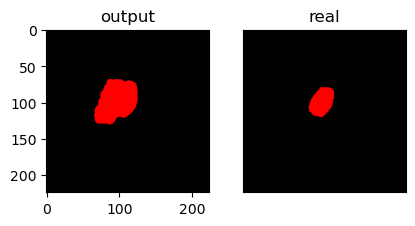

tensor(0)
outputs torch.Size([3, 224, 224])


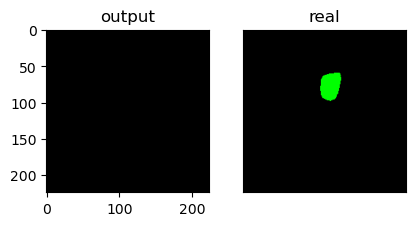

tensor(0)
outputs torch.Size([3, 224, 224])


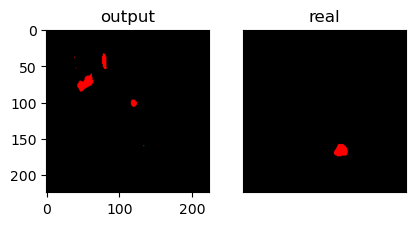

tensor(0)
outputs torch.Size([3, 224, 224])


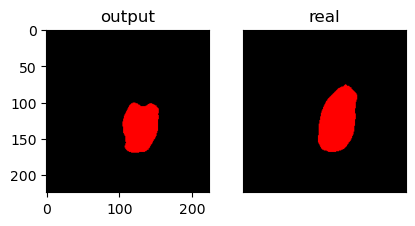

tensor(0)
outputs torch.Size([3, 224, 224])


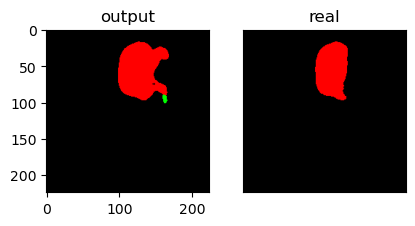

tensor(0)
outputs torch.Size([3, 224, 224])


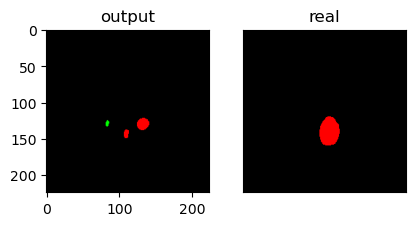

tensor(0)
outputs torch.Size([3, 224, 224])


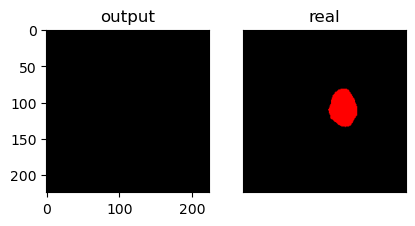

tensor(0)
outputs torch.Size([3, 224, 224])


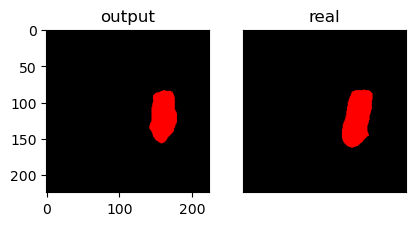

tensor(0)
outputs torch.Size([3, 224, 224])


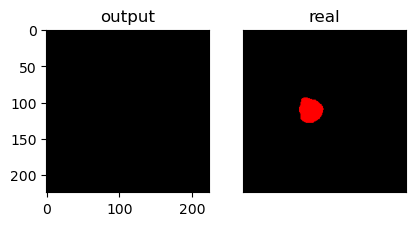

tensor(0)
outputs torch.Size([3, 224, 224])


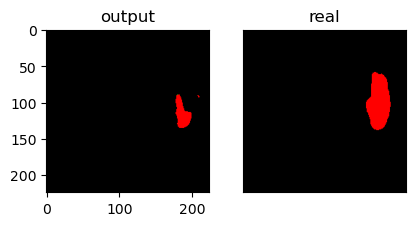

tensor(0)
outputs torch.Size([3, 224, 224])


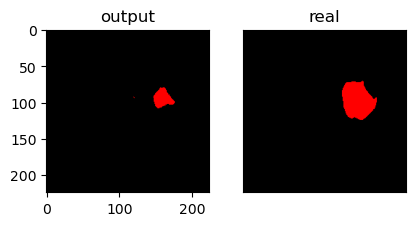

tensor(0)
outputs torch.Size([3, 224, 224])


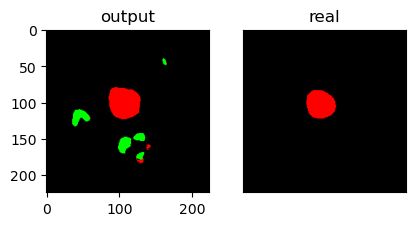

tensor(0)
outputs torch.Size([3, 224, 224])


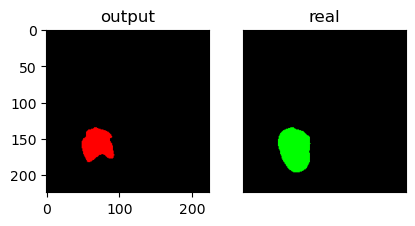

tensor(0)
outputs torch.Size([3, 224, 224])


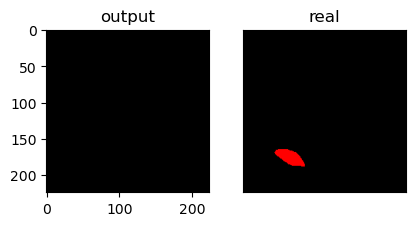

tensor(0)
outputs torch.Size([3, 224, 224])


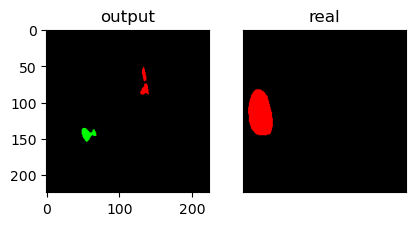

tensor(0)
outputs torch.Size([3, 224, 224])


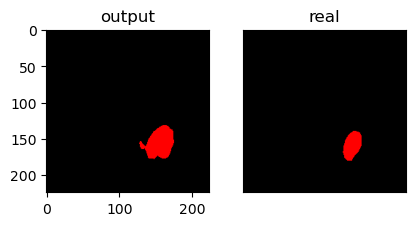

tensor(0)
outputs torch.Size([3, 224, 224])


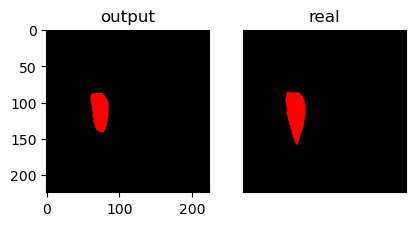

tensor(0)
outputs torch.Size([3, 224, 224])


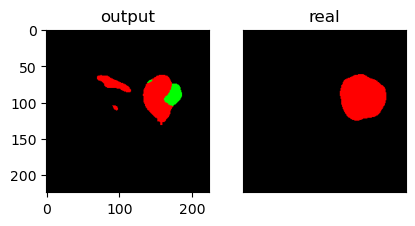

tensor(0)
outputs torch.Size([3, 224, 224])


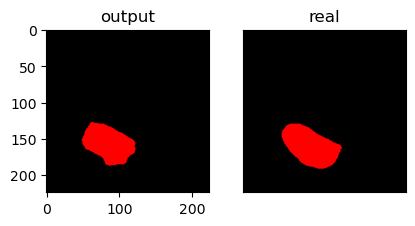

tensor(0)
outputs torch.Size([3, 224, 224])


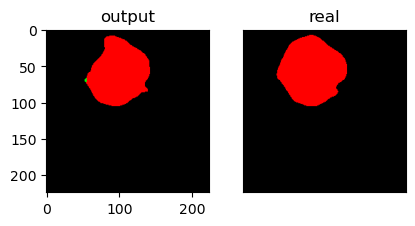

tensor(0)
outputs torch.Size([3, 224, 224])


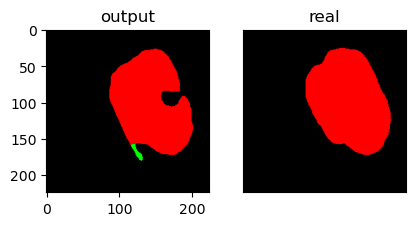

tensor(0)
outputs torch.Size([3, 224, 224])


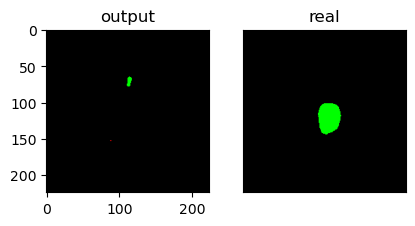

tensor(0)
outputs torch.Size([3, 224, 224])


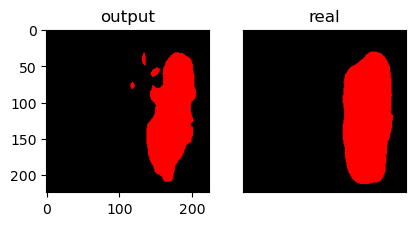

tensor(0)
outputs torch.Size([3, 224, 224])


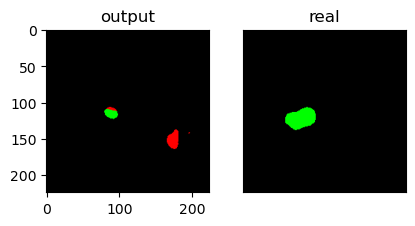

tensor(0)
outputs torch.Size([3, 224, 224])


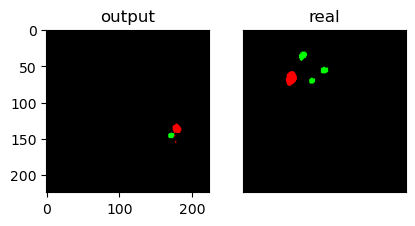

tensor(0)
outputs torch.Size([3, 224, 224])


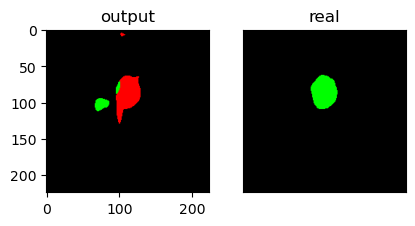

tensor(0)
outputs torch.Size([3, 224, 224])


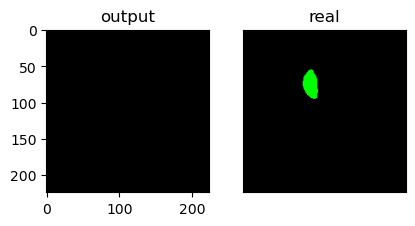

tensor(0)
outputs torch.Size([3, 224, 224])


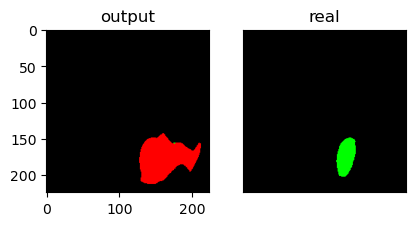

tensor(0)
outputs torch.Size([3, 224, 224])


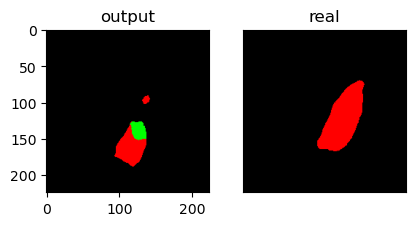

tensor(0)
outputs torch.Size([3, 224, 224])


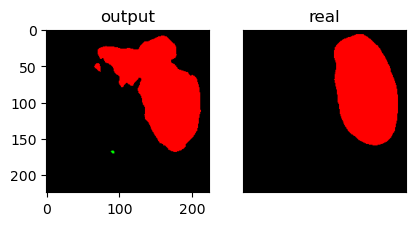

tensor(0)
outputs torch.Size([3, 224, 224])


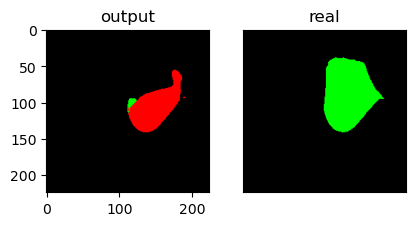

tensor(0)
outputs torch.Size([3, 224, 224])


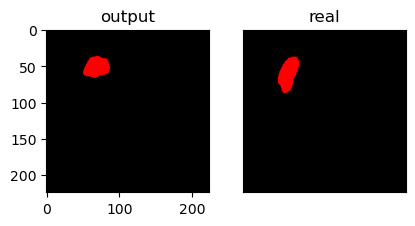

tensor(0)
outputs torch.Size([3, 224, 224])


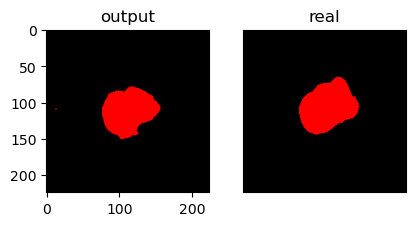

tensor(0)
outputs torch.Size([3, 224, 224])


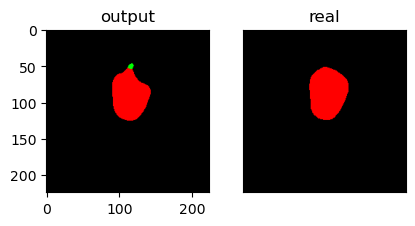

tensor(0)
outputs torch.Size([3, 224, 224])


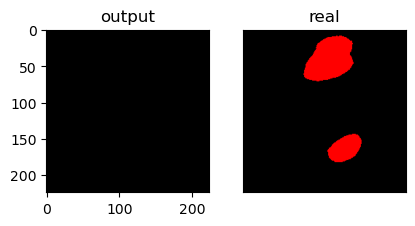

tensor(0)
outputs torch.Size([3, 224, 224])


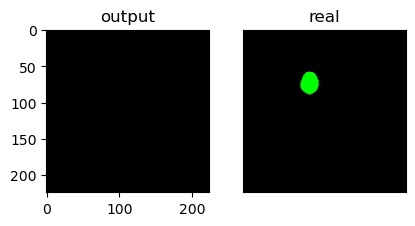

tensor(0)
outputs torch.Size([3, 224, 224])


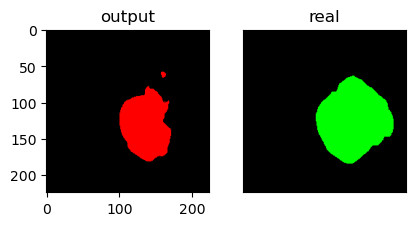

tensor(0)
outputs torch.Size([3, 224, 224])


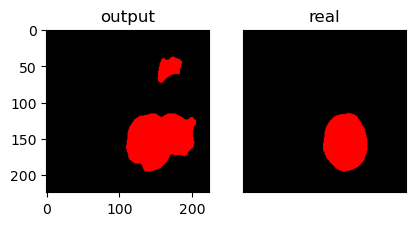

tensor(0)
outputs torch.Size([3, 224, 224])


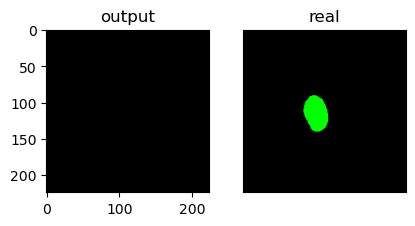

tensor(0)
outputs torch.Size([3, 224, 224])


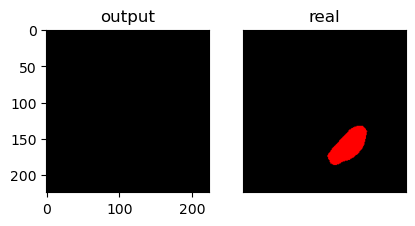

tensor(0)
outputs torch.Size([3, 224, 224])


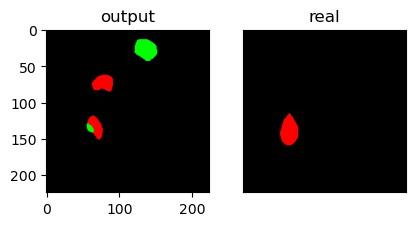

tensor(0)
outputs torch.Size([3, 224, 224])


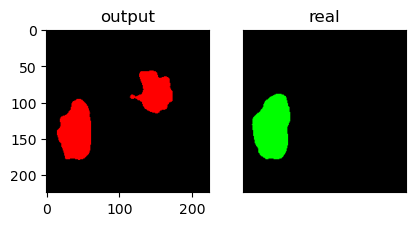

tensor(0)
outputs torch.Size([3, 224, 224])


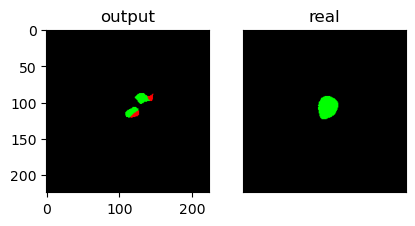

tensor(0)
outputs torch.Size([3, 224, 224])


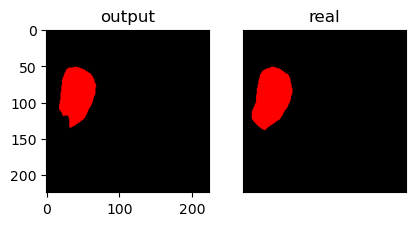

tensor(0)
outputs torch.Size([3, 224, 224])


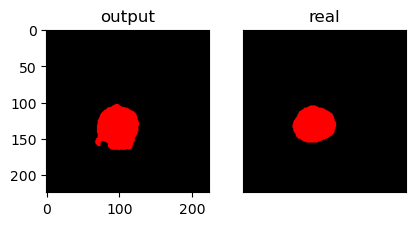

tensor(0)
outputs torch.Size([3, 224, 224])


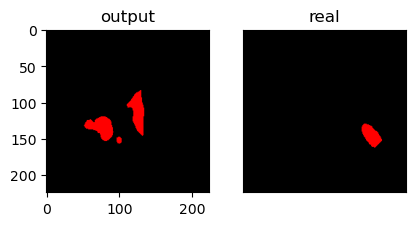

tensor(0)
outputs torch.Size([3, 224, 224])


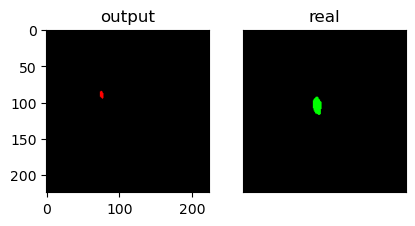

tensor(0)
outputs torch.Size([3, 224, 224])


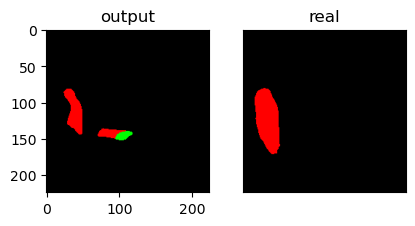

tensor(0)
outputs torch.Size([3, 224, 224])


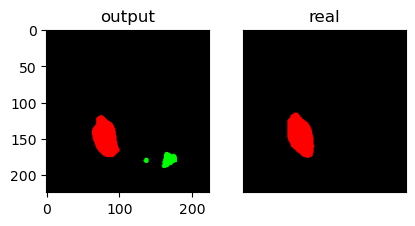

In [29]:
model = PolypModel()
checkpoint = torch.load('/kaggle/working/colorization_model_2.pth')
model.load_state_dict(checkpoint['model_state_dict'])
# model.load_state_dict(torch.load('/kaggle/input/model-ver9h/colorization_model_49.pth'))
# model.load_state_dict(torch.load('/kaggle/input/model-ver9h/colorization_model_49.pth',map_location=torch.device('cpu')))
test_loader = DataLoader(test_dataset, batch_size=1)
test_mask_loader = DataLoader(test_mask_dataset, batch_size=1)
# test_loader = DataLoader(train_dataset, batch_size=1)
# test_mask_loader = DataLoader(mask_dataset, batch_size=1)
model.eval()
loop=0
i=1
with torch.no_grad():
    for RGB,RGBt in zip(test_loader, test_mask_loader):
        loop = loop +1
        if loop == 60:
            break
#         print(AB.shape)
        # Forward pass
        outputs = model(RGB)
        RGBt = RGBt.squeeze()
        outputs = outputs.squeeze()
        count = (outputs == 0).sum()
        print(count)
        print("outputs",outputs.shape)
        
#         outputs = outputs.astype(np.uint8)
#         print(outputs)
        outputs = np.argmax(outputs, axis=0)
#         print(outputs)

#         print(outputs.shape)
        outputs = mask_to_rgb(outputs, color_dict)
        RGBt = mask_to_rgb(RGBt, color_dict)
#         output = mask_to_rgb(outputs, color_dict)
#         output = ((output+0)*1).astype(np.uint8)

#         output_image = np.zeros((224, 224, 3))
#         output_image[:, :, 0:] = outputs.numpy().squeeze().transpose((1, 2, 0))      
#         output_image[:, :, 0] = L.numpy().squeeze()
#         output_image = ((output_image+1)*127.5).astype(np.uint8)
#         output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

        
#         intput_image = np.zeros((224, 224, 3))
# #         intput_image[:, :, 0] = L.numpy().squeeze()
#         intput_image[:, :, 0:] = RGBt
#         intput_image = ((intput_image+1)*127.5).astype(np.uint8)
# #         intput_image = cv2.cvtColor(intput_image, cv2.COLOR_LAB2RGB)

#         # Convert output to RGB color space
# #         output_image = cv2.cvtColor(output_image, cv2.COLOR_LAB2RGB)
        
        
        plt.figure(figsize=(30,30))
        plt.subplot(12,12,i)
        plt.title('output')
        plt.imshow(outputs)
        plt.subplot(12,12,i+1)
        plt.title('real')
        plt.imshow(RGBt)

# #         plt.imshow(output_image, interpolation = 'bicubic')
#         ip_image = np.zeros((224, 224, 3))

        
#         lab_image = cv2.cvtColor(output_image, cv2.COLOR_RGB2LAB)
#         Li, Ai, Bi = cv2.split(lab_image)
# #         Li.fill(255)
#         Ai.fill(128)
#         Bi.fill(128)
#         image_lab = cv2.merge([Li, Ai, Bi])

#         # Convert back to RGB color space if needed
#         image_rgb = cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)
        
#         plt.subplot(12,12,i)
#         plt.title('input')
#         plt.imshow(image_rgb)
        i=i+2
        # Check the size of L, A, B channels
        plt.xticks([]), plt.yticks([]) # optional line of code, just to hide tick values on X and Y axis if needed
        plt.show()


In [ ]:
model = PolypModel()
checkpoint = torch.load('/kaggle/input/model-000001/colorization_model_20.pth')
model.load_state_dict(checkpoint['model_state_dict'])
# model.load_state_dict(torch.load('/kaggle/input/model-ver9h/colorization_model_49.pth'))
# model.load_state_dict(torch.load('/kaggle/input/model-ver9h/colorization_model_49.pth',map_location=torch.device('cpu')))
test_loader = DataLoader(test_dataset, batch_size=1)
test_mask_loader = DataLoader(test_mask_dataset, batch_size=1)
# test_loader = DataLoader(train_dataset, batch_size=1)
# test_mask_loader = DataLoader(mask_dataset, batch_size=1)
model.eval()
loop=0
i=1
with torch.no_grad():
    for L,AB in zip(test_loader, test_mask_loader):
        loop = loop +1
        if loop == 60:
            break
#         print(AB.shape)
        # Forward pass
        outputs = model(L)
        output_image = np.zeros((224, 224, 3))
        output_image[:, :, 1:] = outputs.numpy().squeeze().transpose((1, 2, 0))      
        output_image[:, :, 0] = L.numpy().squeeze()
        output_image = ((output_image+1)*127.5).astype(np.uint8)
        
        intput_image = np.zeros((224, 224, 3))
        intput_image[:, :, 0] = L.numpy().squeeze()
        intput_image[:, :, 1:] = AB.numpy().squeeze().transpose((1, 2, 0))
        intput_image = ((intput_image+1)*127.5).astype(np.uint8)
        intput_image = cv2.cvtColor(intput_image, cv2.COLOR_LAB2RGB)

        # Convert output to RGB color space
        output_image = cv2.cvtColor(output_image, cv2.COLOR_LAB2RGB)
        
        
        plt.figure(figsize=(30,30))
        plt.subplot(12,12,i+1)
        plt.title('output')
        plt.imshow(output_image)
        plt.subplot(12,12,i+2)
        plt.title('real')
        plt.imshow(intput_image)

#         plt.imshow(output_image, interpolation = 'bicubic')
        
        lab_image = cv2.cvtColor(output_image, cv2.COLOR_RGB2LAB)
        Li, Ai, Bi = cv2.split(lab_image)
#         Li.fill(255)
        Ai.fill(128)
        Bi.fill(128)
        image_lab = cv2.merge([Li, Ai, Bi])

        # Convert back to RGB color space if needed
        image_rgb = cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)
        
        plt.subplot(12,12,i)
        plt.title('input')
        plt.imshow(image_rgb)
        i=i+3
        # Check the size of L, A, B channels
        plt.xticks([]), plt.yticks([]) # optional line of code, just to hide tick values on X and Y axis if needed
        plt.show()
